# Chapter 9 - Support Vector Machines

[9.3 Support Vector Machines](#9.3-Support-Vector-Machines)
> [9.3.3 An Application to the Heart Disease Data](#9.3.3-An-Application-to-the-Heart-Disease-Data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC

%matplotlib inline
plt.style.use('seaborn-white')

## 9.3 Support Vector Machines

### 9.3.3 An Application to the Heart Disease Data

In [2]:
df_heart = pd.read_csv('Data/Heart.csv', index_col=0).dropna()
for cat_col in ['ChestPain', 'Thal', 'AHD']:
    df_heart[cat_col] = df_heart[cat_col].astype('category')
    print(f'{cat_col}: {df_heart[cat_col].cat.categories.values}')
df_heart.head(3)

ChestPain: ['asymptomatic' 'nonanginal' 'nontypical' 'typical']
Thal: ['fixed' 'normal' 'reversable']
AHD: ['No' 'Yes']


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [3]:
X = pd.get_dummies(df_heart.drop(['AHD'], axis=1), drop_first=True)
y = df_heart.AHD.map({'Yes': 1, 'No': 0})
X.head(3)

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable
1,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,1,0,0
2,67,1,160,286,0,2,108,1,1.5,2,3.0,0,0,0,1,0
3,67,1,120,229,0,2,129,1,2.6,2,2.0,0,0,0,0,1


In [4]:
y.head()

1    0
2    1
3    1
4    0
5    0
Name: AHD, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=90)

In [6]:
# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_LDA = lda.predict_proba(X_test)[:,1]
*roc_LDA, _ = roc_curve(y_test, y_pred_LDA)
roc_auc_LDA = auc(*roc_LDA)

In [7]:
# SVC
svc = make_pipeline(StandardScaler(), LinearSVC())
svc.fit(X_train, y_train)
y_pred_SVC = svc.decision_function(X_test)
*roc_SVC, _ = roc_curve(y_test, y_pred_SVC)
roc_auc_SVC = auc(*roc_SVC)

In [8]:
# SVM
gammas = [1e-3, 1e-2, 1e-1]
roc_SVMs = []
roc_auc_SVMs = []
for gamma in gammas:
    svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=gamma))
    svm.fit(X_train, y_train)
    y_pred_SVM = svm.decision_function(X_test)
    *roc_SVM, _ = roc_curve(y_test, y_pred_SVM)
    roc_auc_SVM = auc(*roc_SVM)
    
    roc_SVMs.append(roc_SVM)
    roc_auc_SVMs.append(roc_auc_SVM)

#### FIGURE 9.11

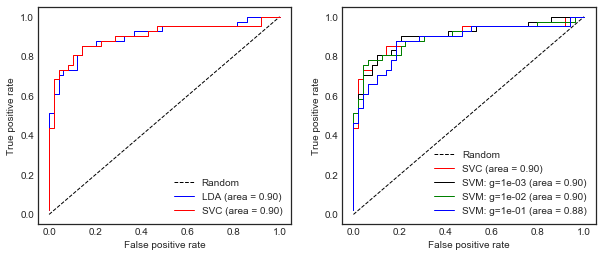

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# LDA vs SVC
ax1.plot(np.linspace(0, 1.0, 100), np.linspace(0, 1.0, 100), color='black', linestyle='--', lw=1, label='Random')
ax1.plot(*roc_LDA, color='blue', lw=1, label=f'LDA (area = {roc_auc_LDA:0.2f})')
ax1.plot(*roc_SVC, color='red', lw=1, label=f'SVC (area = {roc_auc_SVC:0.2f})')
ax1.legend();

# SVC vs SVM
ax2.plot(np.linspace(0, 1.0, 100), np.linspace(0, 1.0, 100), color='black', linestyle='--', lw=1, label='Random')
ax2.plot(*roc_SVC, color='red', lw=1, label=f'SVC (area = {roc_auc_SVC:0.2f})')
for i, color in enumerate(['black', 'green', 'blue']):
    ax2.plot(*roc_SVMs[i], color=color, lw=1, label=f'SVM: g={gammas[i]:1.0e} (area = {roc_auc_SVMs[i]:0.2f})')
ax2.legend();

for ax in [ax1, ax2]:
    ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')